In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import*

In [5]:
torch.cuda.set_device(1)

### Getting and converting the data 

In [6]:
path=untar_data(URLs.BIWI_HEAD_POSE)

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal',skip_footer=6);cal #calibration file

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [8]:
fname = '09/frame_00667_rgb.jpg'

In [14]:
def img2txt_name(f):
    return path/f'{str(f)[:-7]}pose.txt'

In [15]:
img=open_image(path/fname)

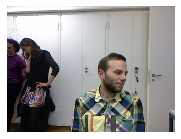

In [16]:
img.show()

In [17]:
ctr=np.genfromtxt(img2txt_name(fname),skip_header=3);ctr

array([187.332 ,  40.3892, 893.135 ])

In [18]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [20]:
get_ctr(fname)

tensor([263.9104, 428.5814])

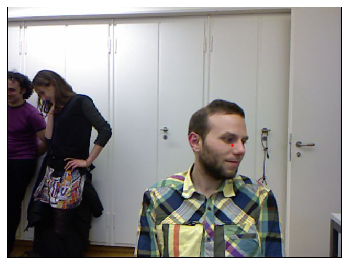

In [22]:
ctr=get_ctr(fname)
img.show(y=get_ip(img,ctr),figsize=(6,6))

### Creating a dataset 

In [24]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(),tfm_y=True,size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

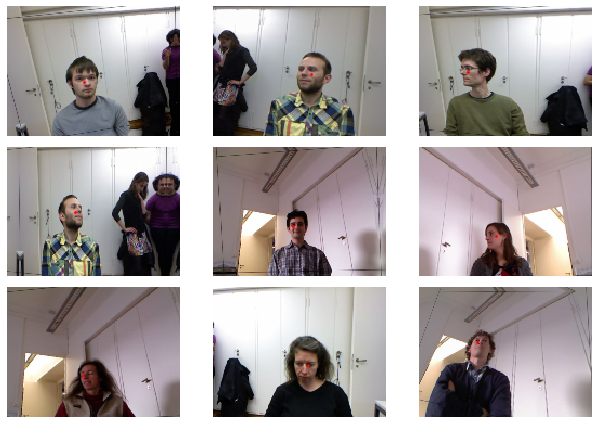

In [25]:
data.show_batch(3,figsize=(9,6))

### Train Model 

In [26]:
learn=cnn_learner(data,models.resnet34)

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


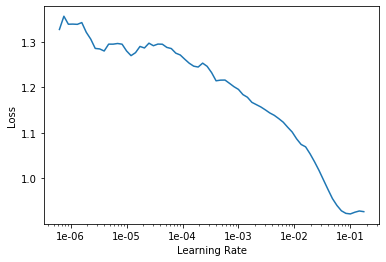

In [28]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5,slice(1.2e-2))

epoch,train_loss,valid_loss,time
0,0.057272,0.006764,00:24
1,0.022614,0.005541,00:24
2,0.010758,0.002041,00:23
3,0.006560,0.001343,00:23
4,0.005036,0.001210,00:23


In [31]:
learn.save('stage-1')

In [35]:
learn.load('stage-1');

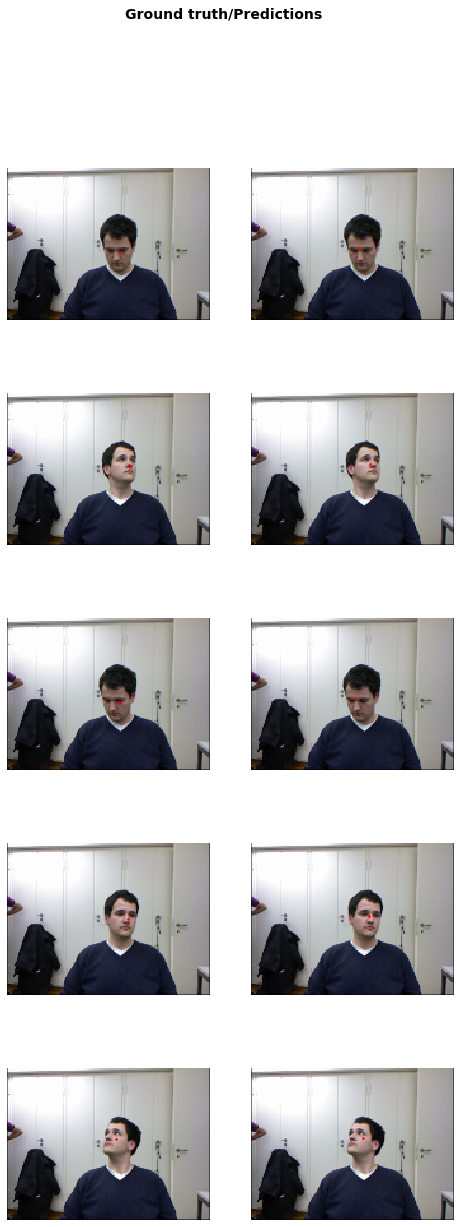

In [36]:
learn.show_results()

### Data Augmentation 

In [37]:
tfms = get_transforms(max_rotate=20,max_zoom=1.5,max_lighting=0.5,max_warp=0.4,p_affine=1.,p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms,tfm_y=True,size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

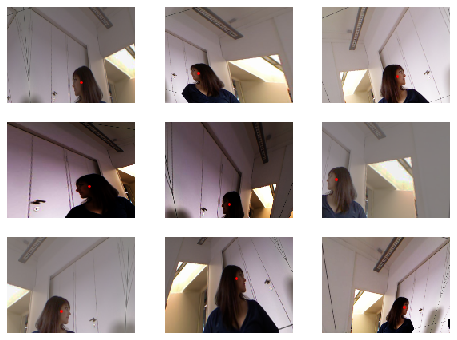

In [44]:
def _plot(i,j,ax):
    x,y = data.train_ds[2]
    x.show(ax,y=y)

plot_multi(_plot,3,3,figsize=(8,6))